# Field-level Irrigation Classification

This notebook demonstrates how to estimate an irrigation probability map for a specific crop field within a farm. We combine the following steps:

- We define an overall region for our analysis containing a crop field of interest. We also define a time range to download data for.
- We segment the desired field with `farm_ai/segmentation/segment_s2` workflow.
- We estimate the irrigation probability map with `farm_ai/water/irrigation_classification` workflow and visualize the results.


### Micromamba environment setup
To install the required packages, see [this README file](../README.md). You can activate the environment with the following command:


```bash
$ micromamba activate farmvibes-ai
```

### Imports & Setup

In [2]:
import os
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from notebook_lib.utils import select_target_time_given_cloud_cover
from shapely import geometry as shpg
from skimage.transform import resize

from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import DataVibe, ExternalReferenceList, gen_guid
from vibe_notebook.plot import lw_plot, transparent_cmap
from vibe_notebook.raster import read_raster, s2_to_img
from vibe_notebook.utils import create_geojson_file_from_point

# Detecting storage directory
config_dir = os.environ.get("XDG_CONFIG_HOME", os.path.expanduser("~/.config"))
storage_config_path = os.path.join(config_dir, "farmvibes-ai", "storage")
with open(storage_config_path) as f:
    storage_dir = f.read().strip()
print(f"Cache directory set to '{storage_dir}' by reading '{storage_config_path}'")

Cache directory set to '/datadrive/' by reading '/home/azureuser/.config/farmvibes-ai/storage'


### Downloading Sentinel-2 data and segmenting crop fields

Let's instantiate our client and define a geometry and time range of interest for our analysis:


In [3]:
client = get_default_vibe_client()

geom = shpg.Point(-102.94, 41.57).buffer(0.05)
time_range = (datetime(2020, 8, 5), datetime(2020, 8, 6))

With those defined, we will download Sentinel-2 data:

In [4]:
# Run the Sentinel-2 download workflow
s2_run = client.run(
    "data_ingestion/sentinel2/preprocess_s2", "S2 - Download", geometry=geom, time_range=time_range
)
s2_run.monitor()

Output()

Let's visualize the downloaded raster. For this particular analysis, let's say we are interested in three fields within this region:

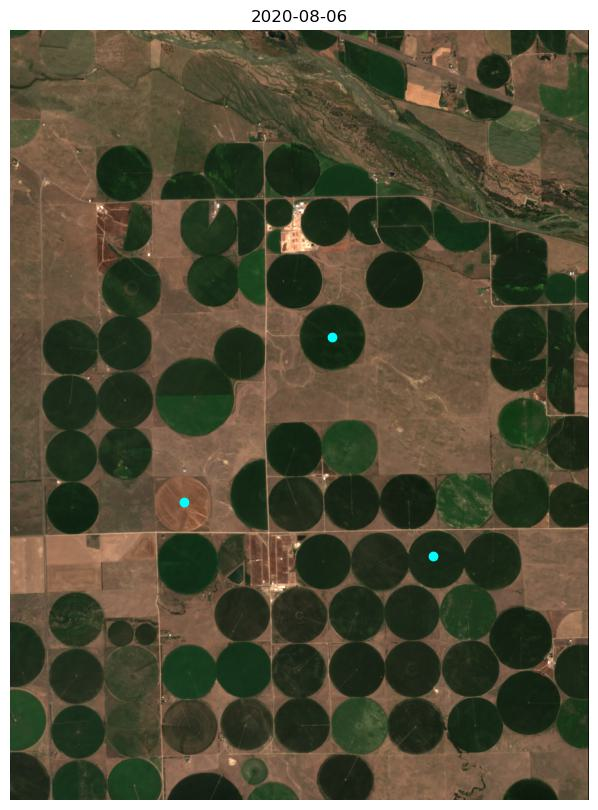

In [5]:
raster = s2_run.output["raster"][0]

# Define the pixel coordinates of the fields that we are interested in (for visualization)
ps = [
    (249.83943263068795, 680.1347085796879),
    (609.9168741200265, 757.9429965708987),
    (464.5292753843096, 442.3727707340149),
]

# Visualize the downloaded raster and points
plt.figure(figsize=(10, 10))
plt.imshow(s2_to_img(read_raster(raster, geom)[0]))
plt.scatter([p[0] for p in ps], [p[1] for p in ps], c="cyan")
plt.title(raster.time_range[0].strftime("%Y-%m-%d"))
plt.axis("off")
lw_plot()

We will use these points as prompts for our segmentation:

In [7]:
# Lat-lon coordinates for those points
point_list = [
    shpg.Point(-102.96042018307406, 41.55914059699734),
    shpg.Point(-102.91749176598168, 41.55136290827474),
    shpg.Point(-102.93400851751896, 41.58008324374019),
]
prompt_ids = [0, 1, 2]
labels = [1, 1, 1]

# Instantiate a geojson with the points to be used for FarmVibes.AI
filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{fid}", time_range=time_range, geometry=shpg.mapping(geom), assets=[], urls=[filepath]
)

# Instantiate the workflow run
roi_time_range = DataVibe(
    id=gen_guid(), time_range=time_range, geometry=shpg.mapping(geom), assets=[]
)

run = client.run(
    "farm_ai/segmentation/segment_s2",
    "SAM segmentation",
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
)
run.monitor()

/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Output()

Let's visualize each crop field mask output by the workflow:

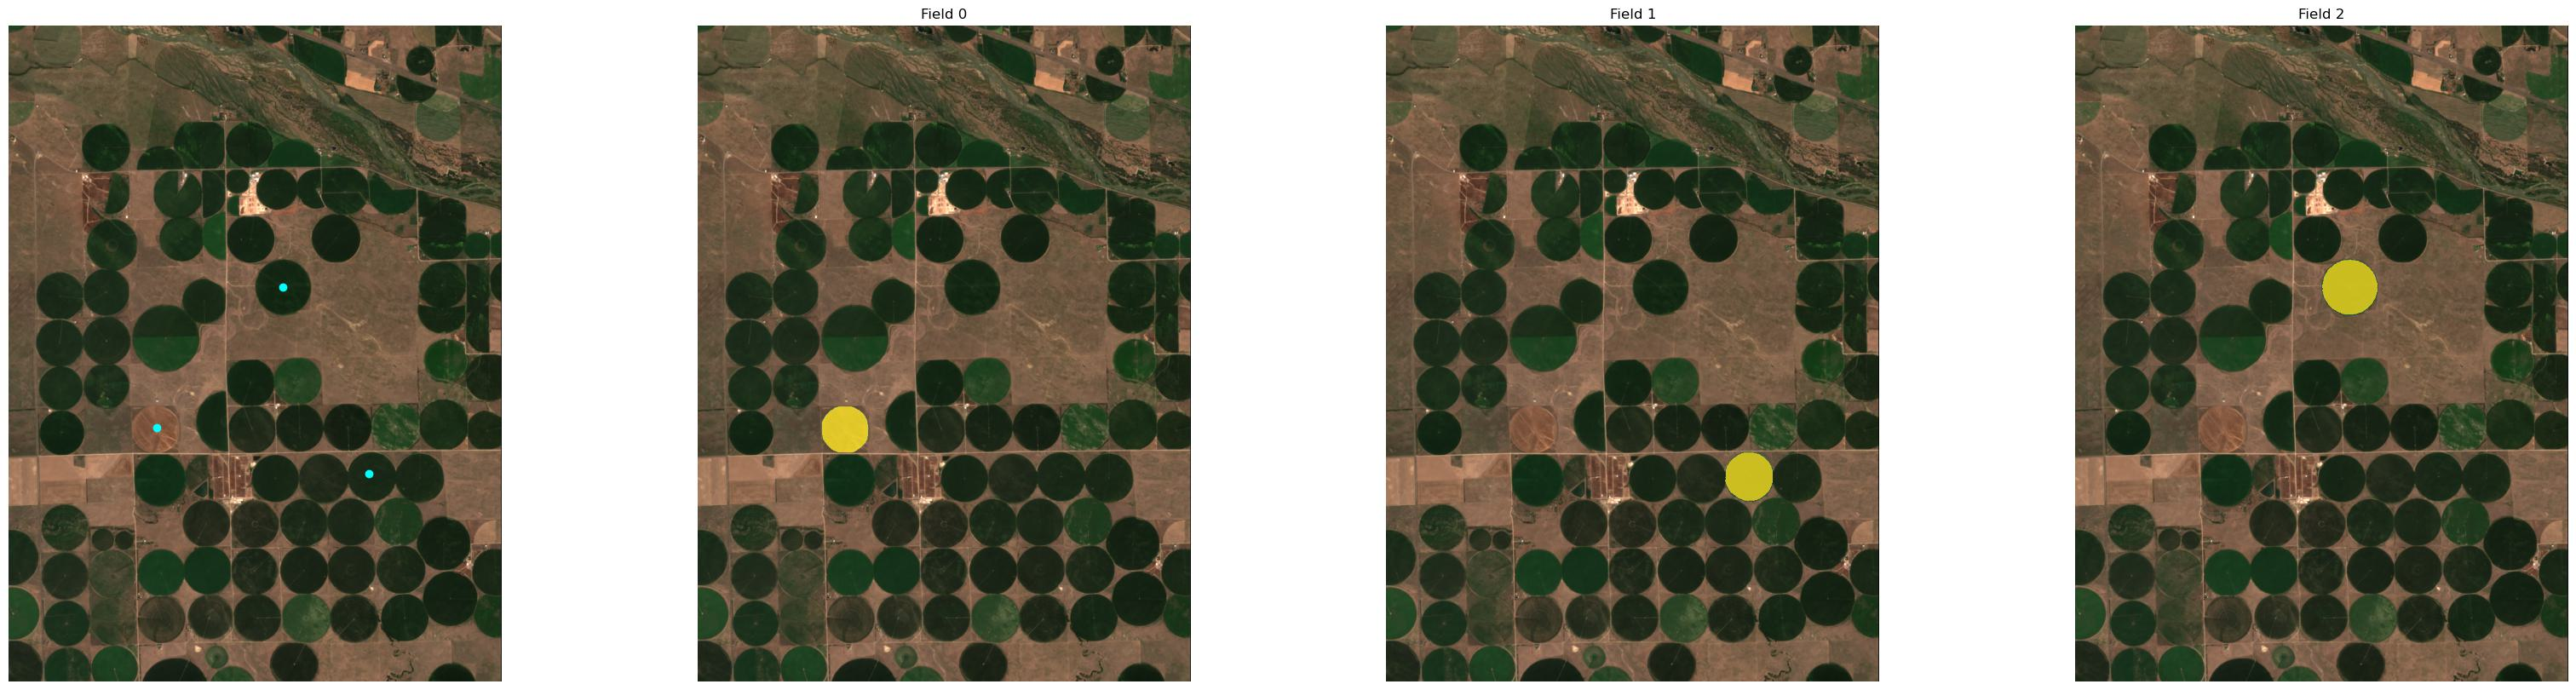

In [8]:
# Reprojecting the raster and points to the same CRS
with rasterio.open(run.output["s2_raster"][0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope
    shpg_points = list(gdf.to_crs(src.crs)["geometry"])

# Reading the raster
ar, transform = read_raster(run.output["s2_raster"][0], projected_geometry=proj_geom)
img = s2_to_img(ar)

# Reading the segmentation mask
mask_ar, _ = read_raster(run.output["segmentation_mask"][0], projected_geometry=proj_geom)

# Transforming the points to pixel coordinates for visualization
ps = [~transform * (shpg_p.x, shpg_p.y) for shpg_p in shpg_points]

# Visualizing the results
plt.figure(figsize=(10 * (1 + mask_ar.shape[0]), 10))
plt.subplot(1, (1 + mask_ar.shape[0]), 1)
plt.imshow(img)
plt.scatter([p[0] for p in ps], [p[1] for p in ps], color="cyan")
plt.axis("off")

for i in range(mask_ar.shape[0]):
    plt.subplot(1, (1 + mask_ar.shape[0]), 2 + i)
    plt.imshow(img)
    plt.imshow(mask_ar[i], cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
    plt.title(f"Field {i}")
    plt.axis("off")
lw_plot()

### Estimating irrigation probability

Now that we have our crop field masks, we can estimate the probability of irrigation for each field:

In [9]:
coords = geom.centroid.coords[0]

# Selecting date with low cloud cover on Landsat tiles for the geometry of interest
_, target_time = select_target_time_given_cloud_cover(coords[1], coords[0], 2020, 8, 6, 0.05, 0.1)

# Run the workflow
irrigation_run = client.run(
    "farm_ai/water/irrigation_classification",
    "Irrigation Classification",
    geometry=geom,
    time_range=(target_time, target_time),
)
irrigation_run.monitor()

/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.10/site-packages/pystac_client/item_search.py:831: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Entered longitude and latitude is: -102.94000000000001 , 41.57000000000002
Assigned Search Date is: 2020 - 8 - 6
Chosen Image Date with Equal or Less than 0.1% Cloud Condition in the Area is: 2020-08-05


Output()

Visualizing the irrigation probability maps:

/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.10/site-packages/skimage/transform/_warps.py:674: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.10/site-packages/skimage/transform/_warps.py:678: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


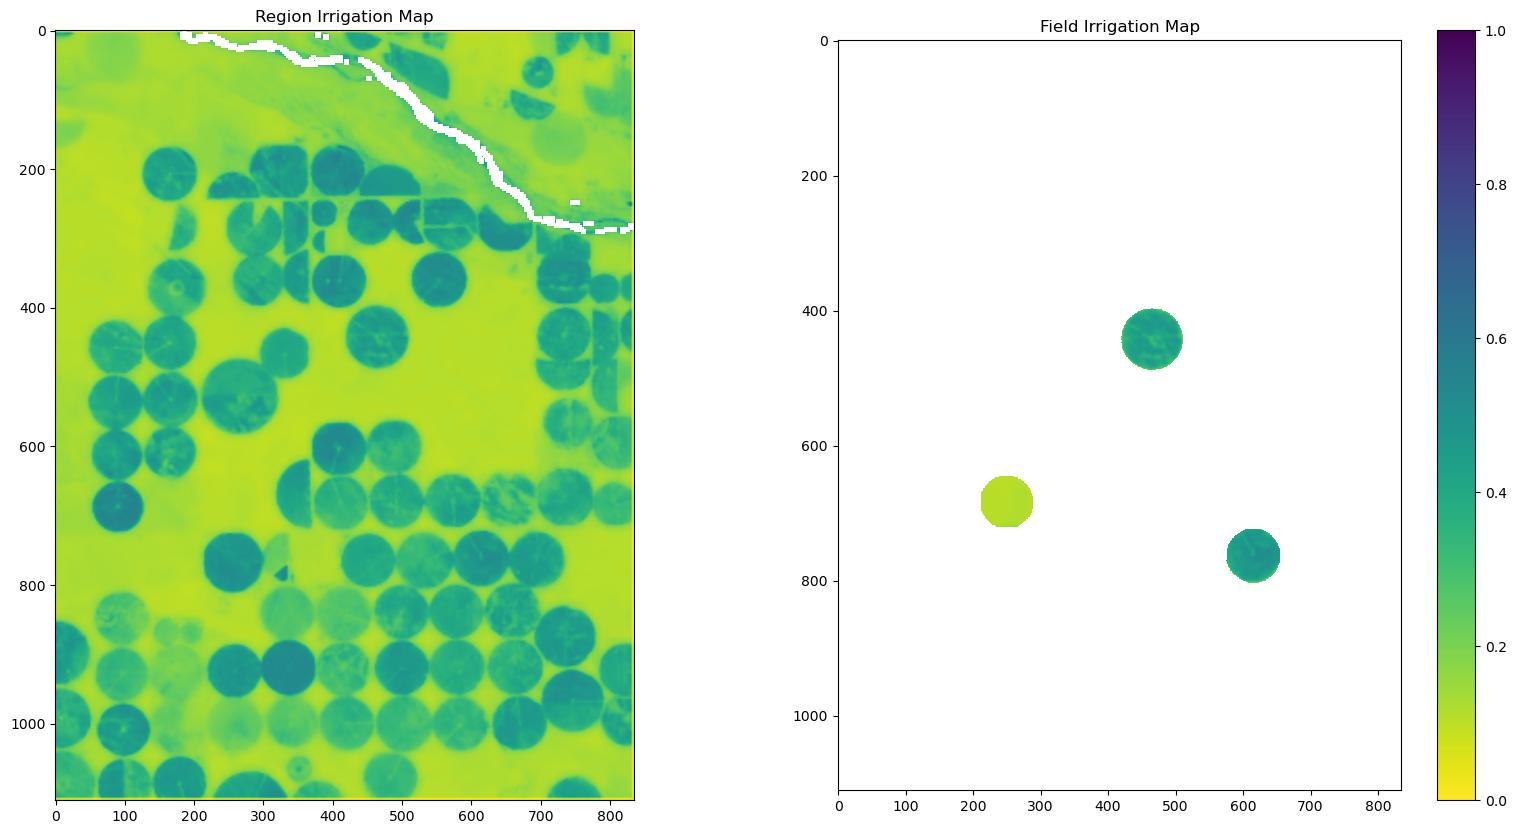

In [10]:
mask, _ = read_raster(irrigation_run.output["irrigation_probability"][0], geometry=geom)

# Upsample the mask to the same resolution as the S2 raster
resized_mask = resize(mask[0], mask_ar.shape[1:], anti_aliasing=True)

# Combining the segmentation mask with the irrigation mask
field_mask = np.any(mask_ar, axis=0)
combined_mask = field_mask * resized_mask
combined_mask = np.where(combined_mask == 0, np.nan, combined_mask)

# Visualizing the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(resized_mask, cmap="viridis_r", vmin=0, vmax=1)
plt.title("Region Irrigation Map")

plt.subplot(1, 2, 2)
plt.imshow(combined_mask, cmap="viridis_r", vmin=0, vmax=1)
plt.title("Field Irrigation Map")
colorbar = plt.colorbar()
lw_plot()

Finally, we can overlay the map with the Sentinel-2 raster: 

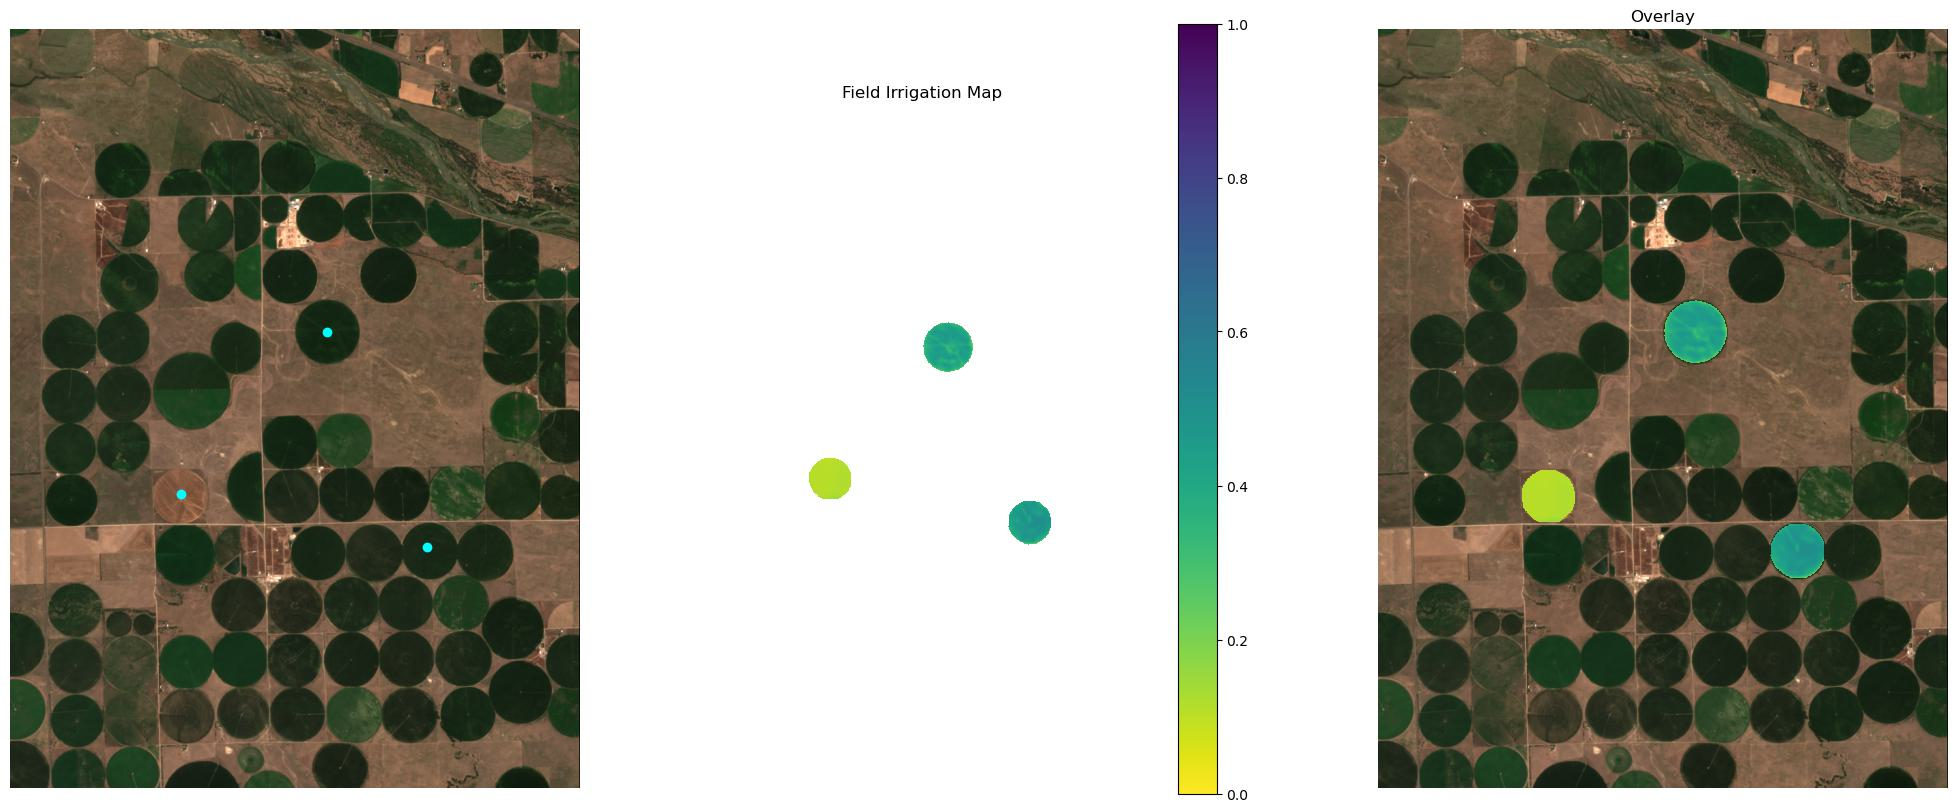

In [11]:
# Visualizing the results
plt.figure(figsize=(25, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.scatter([p[0] for p in ps], [p[1] for p in ps], color="cyan")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(combined_mask, cmap="viridis_r", vmin=0, vmax=1)
plt.title("Field Irrigation Map")
colorbar = plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(combined_mask, cmap="viridis_r", vmin=0, vmax=1)
plt.title("Overlay")
plt.axis("off")

lw_plot()

We can also compute a per field summary of the irrigation probability:

In [13]:
irrigation_per_field = [resized_mask * mask for mask in mask_ar]
irrigation_per_field = [np.where(m == 0, np.nan, m) for m in irrigation_per_field]
avg_irrigation_per_field = [np.nanmean(m) for m in irrigation_per_field]

for i, avg_irrigation in enumerate(avg_irrigation_per_field):
    print(f"Field {i} average irrigation probability: {avg_irrigation*100:.2f}%")

Field 0 average irrigation probability: 11.22%
Field 1 average irrigation probability: 43.73%
Field 2 average irrigation probability: 39.24%
